### Seminar Tutorial


This notebook summarizes `slmsuite` examples.

The following header imports packages and defines helper functions.

In [1]:
# Header.

# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, time
import numpy as np
import cv2
import scipy.ndimage as ndimage

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../../..'))

from slmsuite.holography import analysis, toolbox
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras import AlliedVision
from slmsuite.hardware.cameraslms import FourierSLM
from slmsuite.holography.algorithms import FeedbackHologram, SpotHologram

# Function to load logos
def load_img(path, target_shape=None, angle=0, shift=(-200, 0), plot=False):
    # Load the image.
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError("Image not found at path '{}'".format(path))

    # Invert if necessary such that the majority of the image is dark.
    if np.mean(img) > np.mean(cv2.bitwise_not(img)):
        img = cv2.bitwise_not(img)

    if angle != 0:
        img = ndimage.rotate(img, angle)

    if target_shape is not None:
        zoom_x = target_shape[0] / img.shape[0]
        zoom_y = target_shape[1] / img.shape[1]
        img = ndimage.zoom(img, min(zoom_x, zoom_y))

    # sqrt to get the amplitude.
    target_ij = toolbox.pad(analysis._make_8bit(np.sqrt(img)), fs.cam.shape)

    # Shift to the desired center.
    target_ij = np.roll(target_ij, shift, axis=(0,1))

    if plot:
        plot_img(target_ij)
        plt.show()

    return target_ij

def plot_img(target_ij):
    # Plot the desired camera space.
    plt.figure(figsize=(20,10))
    plt.imshow(target_ij)
    plt.plot(target_ij.shape[1]/2, target_ij.shape[0]/2, 'r*')

def load_composite_img(paths, plot=True):
    N = len(paths)

    shape0 = fs.cam.shape
    shape = (int(shape0[0]/3), int(shape0[1]))

    result = toolbox.lloyds_points(shape, N, iterations=50, plot=False)
    toolbox.voronoi_windows(shape, result, plot=True)
    max_size = toolbox.smallest_distance(result)
    final = None

    for index, path in enumerate(paths):
        img = load_img(
            path, 
            target_shape=(max_size, max_size), 
            shift=(int(result[1, index] - shape[0]/2), int(result[0, index] - shape[1]/2))
        )

        if final is None:
            final = img
        else:
            final += img

    final = np.roll(toolbox.pad(final, shape0), shift=(-int(shape0[0] / 4), 0), axis=(0,1))

    plot_img(final)

    # for index, path in enumerate(paths):
    #     plt.annotate(path,
    #         (int(result[1, index] - shape[0]/2), int(result[0, index] - shape[1]/2)),
    #         c="r", size="x-small", ha="center")

    plt.show()

    return final
    
cyi = 90
cyf = 453

def plot_data(title=' Computational', cyi=0, cyf=-1):
    fs.slm.write(hologram.extract_phase(), settle=True)

    img = fs.cam.get_image()

    # limits = hologram.plot_farfield(hologram.weights, title='Weights' + title)
    # hologram.plot_farfield(hologram.ijcam_to_knmslm(img), limits=limits, title='Exp. Result' + title)
    
    imgs[title.strip()] = img[cyi:cyf, :]

    plt.figure(figsize=(24, 12))
    plt.imshow(imgs[title.strip()])
    plt.show()

def plot_target(target, title='Target'):
    plt.figure(figsize=(24, 12))
    plt.imshow(target[cyi:cyf, :])
    plt.show()

shape = (2048, 2048)

screenmirrored.py: pyglet not installed. Install to use ScreenMirrored SLMs.
filr.py: PySpin not installed. Install to use FLIR cameras.
thorlabs.py: thorlabs_tsi_sdk not installed. Install to use Thorlabs cameras.


#### Loading Hardware

**Cameras** and **SLMs** are connected to python by a myriad of SDKs, often provided by hardware
vendors. However, these SDKs likewise have a myriad of function names and hardware-specific
quirks. Thus, hardware in `slmsuite` is integrated as subclasses of
the abstract classes `.Camera` and `.SLM`.
These subclasses for [cameras](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.html) 
and [slms](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.html)
are effectively wrappers for given SDKs, implemented with standardized methods and syntax that the rest of `slmsuite` can understand, but also include
quality-of-life features.
If you believe your camera or SLM is not supported by the currently available classes, please 
[open a GitHub issue](https://github.com/QPG-MIT/slmsuite/issues) 
or [feel free to write an interface yourself](https://github.com/QPG-MIT/slmsuite/blob/main/CONTRIBUTING.md)!

First, let's load an SLM. We're running this notebook with a `Santec` SLM.
We can find connected displays with the `.info()` static method.

In [2]:
from slmsuite.hardware.slms.santec import Santec
Santec.info(verbose=True);

Displays detected by Santec
display_number, display_name:
1,  HP S2231,HWP,2905,3CQ02001CN
2,  LCOS-SLM,SOC,8001,2018021001


We see that `display_number=2` is the display with the LCoS SLM. We're running this setup with a 633 nm HeNe laser. All functions are documented, including the below 
[initializer](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.santec.Santec.html#slmsuite.hardware.slms.santec.Santec.__init__).

In [3]:
slm = Santec(slm_number=1, display_number=2, wav_um=.633)

Santec slm_number=1 initializing... success
Looking for display_number=2... success
Opening LCOS-SLM,SOC,8001,2018021001... success


Next, let's load a camera. We're running this notebook with a `AlliedVision` camera. We can find connected cameras with the `.info()` static method.

In [4]:
from slmsuite.hardware.cameras.alliedvision import AlliedVision
AlliedVision.info(verbose=True);

AlliedVision serials:
"02C5V"
"08-406808001844"


We want the `"02C5V"` serial.

In [5]:
cam = AlliedVision(serial="02C5V", verbose=True)

vimba initializing... success
Looking for cameras... success
vimba sn 02C5V initializing... success


Lastly, we'll make a [class for our composite optical system](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM), 
consisting of the camera and the SLM. We'll also load a previously-measured 
[wavefront calibration](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameraslms.FourierSLM.html#slmsuite.hardware.cameraslms.FourierSLM.wavefront_calibrate)
(we'll come back to this!).

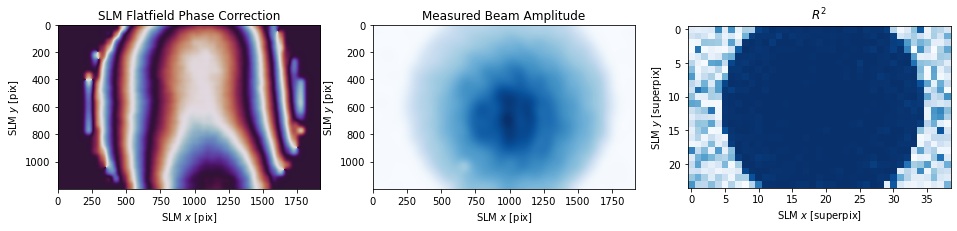

In [6]:
from slmsuite.hardware.cameraslms import FourierSLM
fs = FourierSLM(cam, slm)
fs.load_wavefront_calibration(plot=True);    # We'll come back to this!

#### Simple Holography

Let's start out with the simplest phase pattern possible: no pattern! We 
[write](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.slms.slm.SLM.html#slmsuite.hardware.slms.slm.SLM.write) 
a flat phase $\phi(\vec{x}) = 0\pi$ to the SLM with `.write()`.

In [7]:
phase = np.zeros(slm.shape)
slm.write(phase, settle=True);      # slm.write(None, settle=True) is equivalent to this.

Great. Let's [take a look](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.hardware.cameras.camera.Camera.html#slmsuite.hardware.cameras.camera.Camera.get_image)
at the result in our camera with `.get_image()`. We'll also set the exposure to an appropriate value.

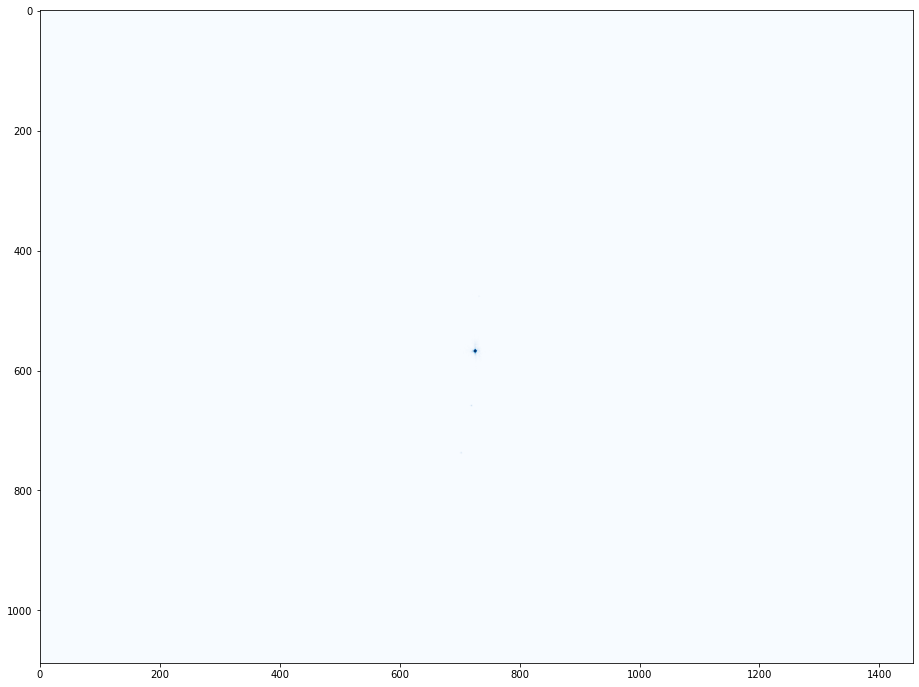

In [8]:
cam.set_exposure(.0002)
img = cam.get_image()

# Plot the result
plt.figure(figsize=(24, 12))
plt.imshow(img)
plt.show()

As expected, we see a spot corresponding to the zero-th order diffraction peak. This spot is focussed at the center of our camera.

We're going to be `.write()`ing phases and `.get`ing`_image()`s a couple more times in this notebook, so we'll define a method `plot_phase()` to help us with that.

In [95]:
def plot_phase(phase, title="", zoom=True):
    # One plot if no camera; two otherwise.
    _, axs = plt.subplots(1, 2 - (cam is None), figsize=(24, 8), gridspec_kw={"width_ratios": (.6, .4)})

    if cam is None:
        axs = [axs]
    
    # Plot the phase.
    axs[0].set_title("SLM Phase")
    im = axs[0].imshow(
        np.mod(phase, 2*np.pi), 
        vmin=0,
        vmax=2*np.pi, 
        interpolation="none", 
        cmap="Blues"
    )
    plt.colorbar(im, ax=axs[0])
    
    # Grab an image of the resulting pattern and plot.
    slm.write(phase, settle=True)
    img = cam.get_image()

    axs[1].set_title("Camera Result")
    axs[1].imshow(img)
    if zoom:
        xlim = axs[1].get_xlim()
        ylim = axs[1].get_ylim()
        axs[1].set_xlim([xlim[0] * .7 + xlim[1] * .3, xlim[0] * .3 + xlim[1] * .7])
        axs[1].set_ylim([ylim[0] * .7 + ylim[1] * .3, ylim[0] * .3 + ylim[1] * .7])

    # Make a title, if given.
    plt.suptitle(title)
    plt.show()

Next, we'll move the laser spot by applying a 
[blazed grating](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.blaze.html#slmsuite.holography.toolbox.blaze)
to the SLM using a helper function from our `toolbox`. This blazed grating has a Fourier spectrum shifted from the origin, so naturally applying this pattern to the SLM will produce a shifted result in the farfield, i.e. in the plane of the camera.

Many common phases patterns are available in the `slmsuite.holography.toolbox`. See the Structured Light example for more information (e.g. the behavior of `grid=`).

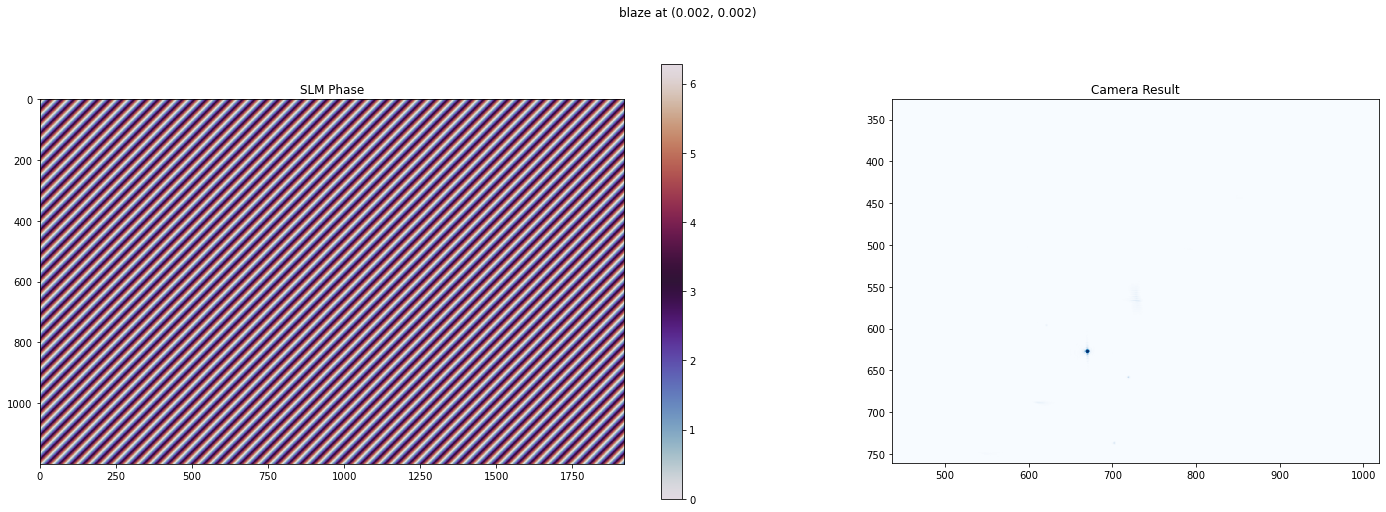

In [42]:
from slmsuite.holography import toolbox

vector = (.002, .002)   # Radians (== normalized units kx/k)
blaze_phase = toolbox.blaze(grid=slm, vector=vector)
plot_phase(blaze_phase, title="blaze at {}".format(vector))

But what units does `vector` have? The default blaze units in `slmsuite` (`"norm"`) are normalized $k_x/k$ units, which are equivalent to radians in the small angle approximation. To get a better handle on what `vector = (.002, .002)` means, we can 
[print](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.print_blaze_conversions.html#slmsuite.holography.toolbox.print_blaze_conversions)
the equivalent vectors converted to supported units with `toolbox.print_blaze_conversions()`.

In [12]:
toolbox.print_blaze_conversions(vector=(.002, .002), from_units="norm", slm=slm)

'norm' : (0.002, 0.002)
'kxy' : (0.002, 0.002)
'knm' : (1008.5308056872038, 630.3317535545024)
'freq' : (0.02527646129541864, 0.02527646129541864)
'lpmm' : (3.1595576619273302, 3.1595576619273302)
'rad' : (0.002, 0.002)
'mrad' : (2.0, 2.0)
'deg' : (0.11459155902616464, 0.11459155902616464)


Okay. So this means that we're diffracting light by an angle of two miliradians or a tenth of a degree.
Of course, all the units are [documented](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.toolbox.convert_blaze_vector.html#slmsuite.holography.toolbox.convert_blaze_vector).

This function wraps `toolbox.convert_blaze_vector()` which handles arbitrary unit conversions. Let's try it out by diffracting light at .2 degrees in the $x$ and $y$ directions.

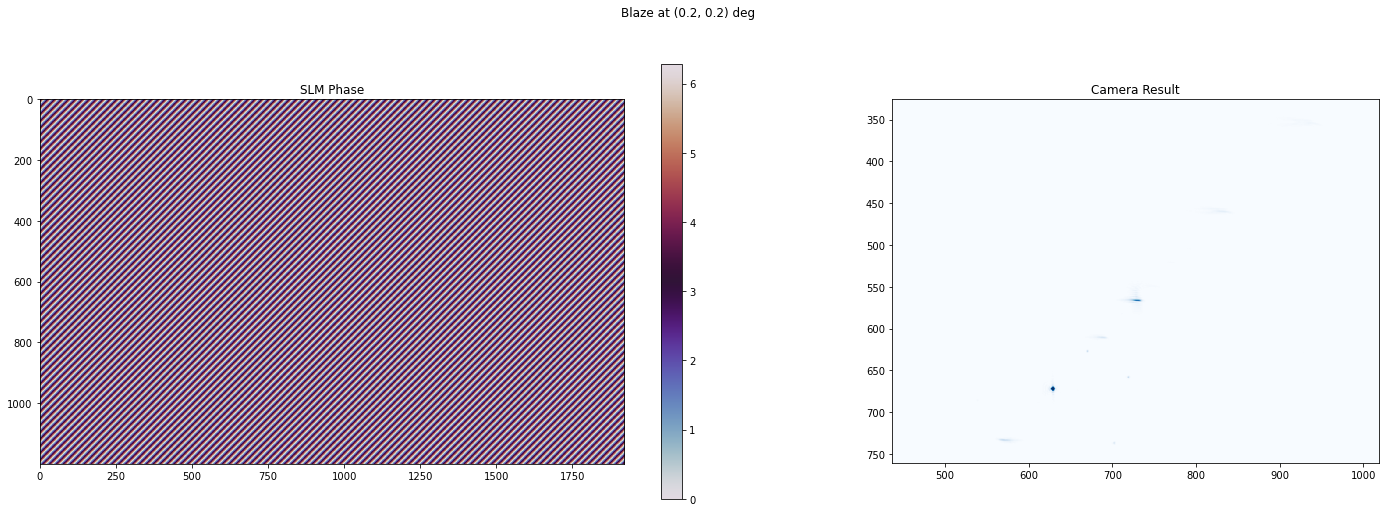

In [43]:
vector_deg = (.2, .2)
vector = toolbox.convert_blaze_vector(vector_deg, from_units="deg", to_units="norm")
blaze_phase = toolbox.blaze(grid=slm, vector=vector)
plot_phase(blaze_phase, title="Blaze at {} deg".format(vector_deg))

All this is good fun, but let's say we wanted our spot right at camera pixel `(600, 600)`. We could iterate by guessing and checking successive `vectors`, but that seems boring and non-pythonic. Instead, we will calibrate a transformation between the $k$-space of the SLM and the space of the camera using features built-in to `slmsuite`.

#### Fourier Calibration

Calibration is simple, just run a built-in function `.fourier_calibrate()` to 1) generate and 2) fit a grid of spots (with known $k$-space coordinates) with an affine transformation to the space of the camera. This grid is generated using 
[techniques](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.algorithms.html)
that we'll discuss later. Care must be taken to choose:

 - A camera exposure such that spots are prominent,
 - A pitch and shape of the array which are visible.

Note that the default array units are in `"knm"` space, or the 
[computational space of holography](https://slmsuite.readthedocs.io/en/latest/_autosummary/slmsuite.holography.algorithms.html). 
Read more about this in later examples.

100%|██████████| 50/50 [00:00<00:00, 93.37it/s] 


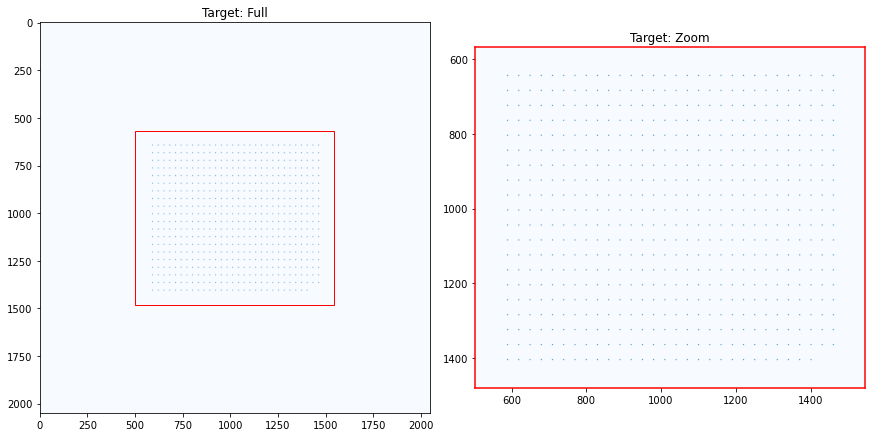

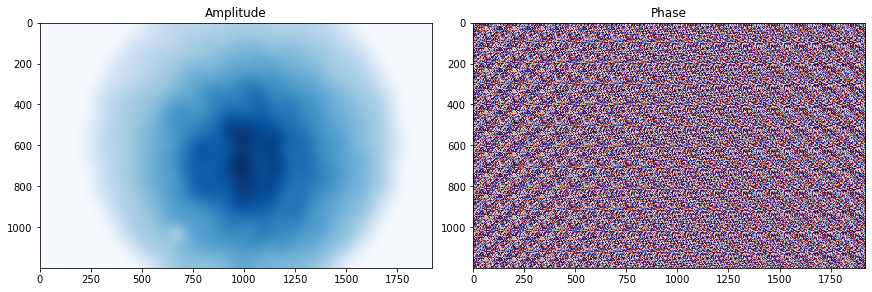

index 1088 is out of bounds for axis 0 with size 1088


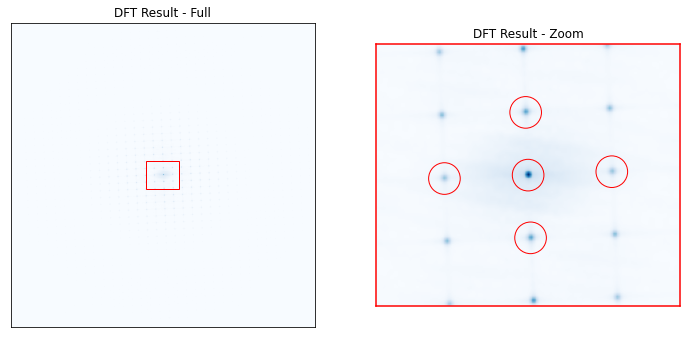

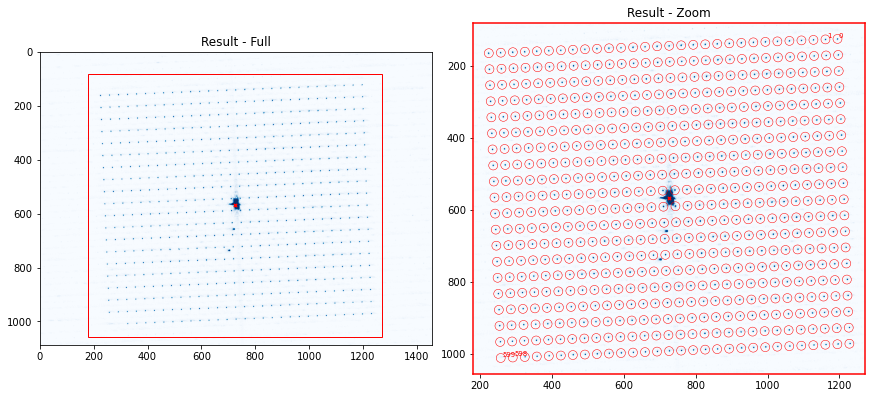

In [14]:
cam.set_exposure(.05)               # Increase exposure because power will be split many ways

fs.fourier_calibrate(
    array_shape=[30, 20],           # Size of the calibration grid (Nx, Ny) [knm]
    array_pitch=[30, 40],           # Pitch of the calibration grid (x, y) [knm]
    plot=True
)

cam.set_exposure(.0002)             # Restore exposure

Notice that there are two missing spots from the array. This is a parity check to make sure the calibration is flipped in the correct direction.

The result of this process is the transformation

$\vec{x} = M \cdot (\vec{k} - \vec{a}) + \vec{b}$

where $\vec{x}$ is in units of camera pixels and $\vec{k}$ is in units of normalized $k$-space. We can view the result in the `fourier_calibration` variable.

In [15]:
fs.fourier_calibration

{'M': array([[-28876.09736229,   1128.53391035],
        [  1181.73152374,  28898.2532227 ]]),
 'b': array([[726.],
        [568.]]),
 'a': array([[-5.42702563e-05],
        [-4.91016605e-05]])}

Now let's use this calibration to achieve our goal of `(600, 600)`. We can find the blaze vector $\vec{k}$ (in normalized units) corresponding to the desired pixel $\vec{x}$ using our calibration.

In [16]:
vector_600_600 = fs.ijcam_to_kxyslm((600, 600))
print(vector_600_600)

[[0.00434545]
 [0.00087831]]


Now let's check this result:

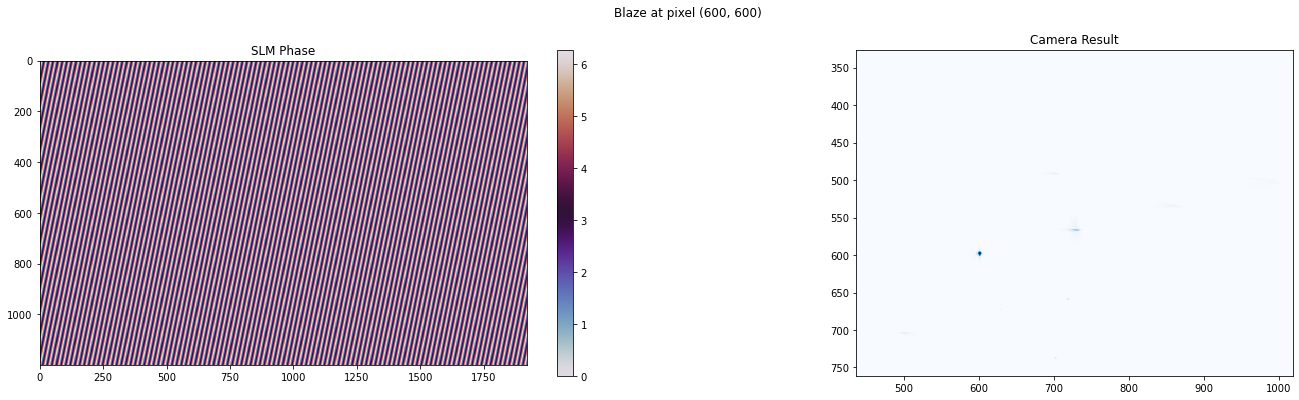

In [28]:
blaze_phase = toolbox.blaze(grid=slm, vector=vector_600_600)
plot_phase(blaze_phase, title="Blaze at pixel (600, 600)")

#### Structured Light

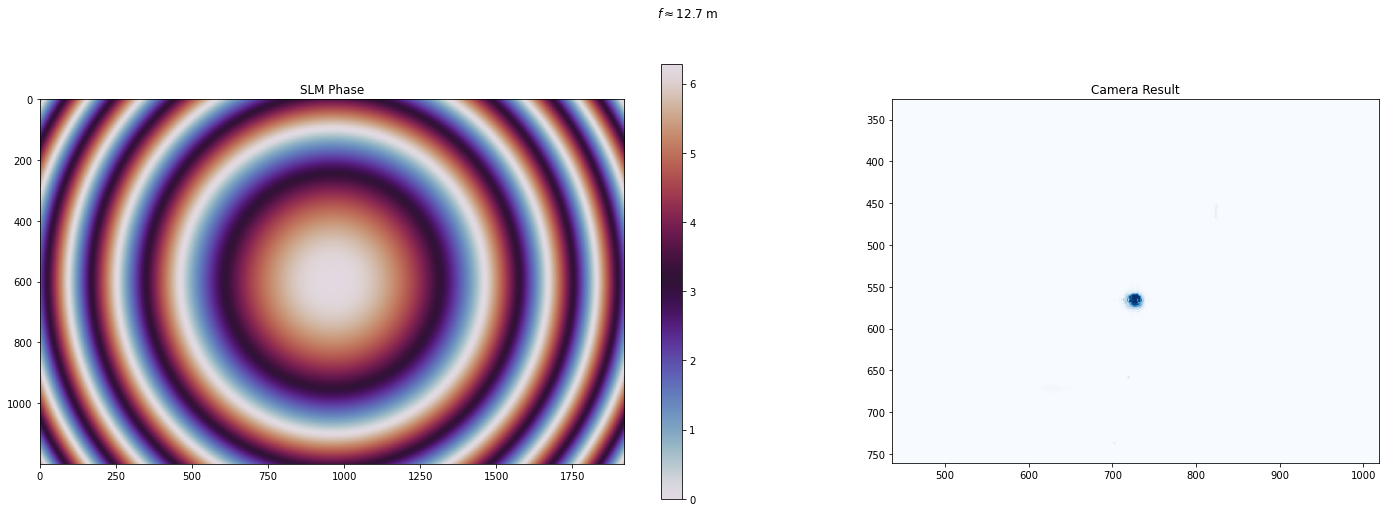

In [44]:
lens_phase = toolbox.lens(grid=slm, f=-2e7)  # f is in normalized f/lambda units. 2e7 ==> 20 million wavelengths ==> 12.7 m
plot_phase(lens_phase, title=r"$f \approx 12.7$ m")

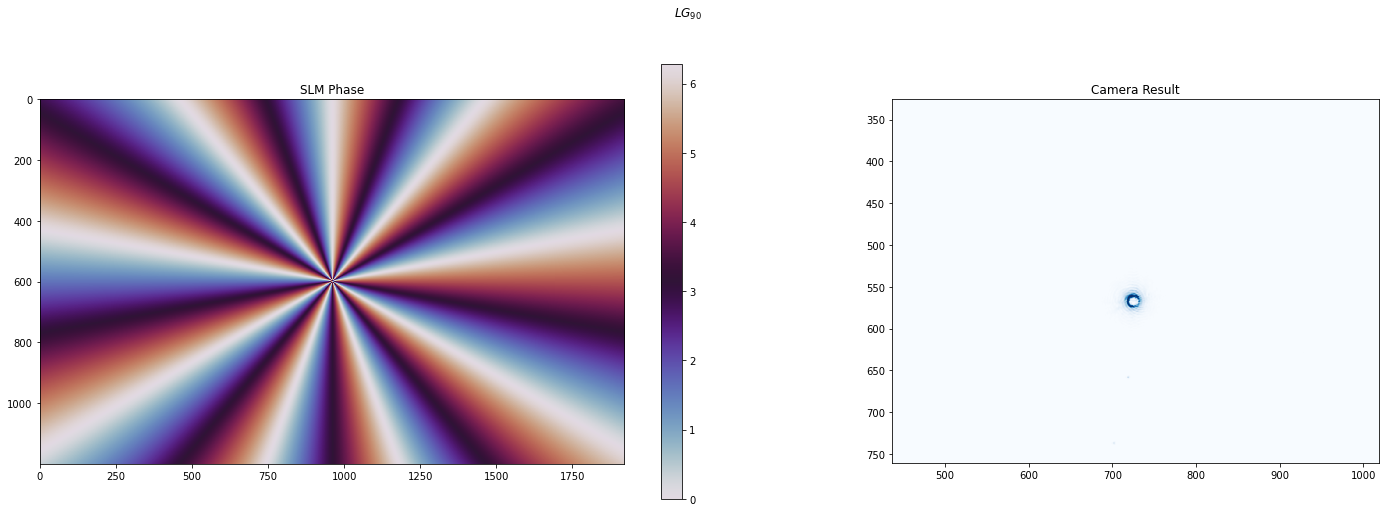

In [46]:
lg90_phase = toolbox.laguerre_gaussian(slm, l=9, p=0)
plot_phase(lg90_phase, title="$LG_{90}$")

#### Wavefront Calibration

Thus far, our examples have made two important assumptions:

- The SLM is perfectly in the Fourier domain without aberration, connected to the imaging domain via Fourier transform, and
- The optical amplitude of the source beam covers the SLM uniformly.

Generally, in practical experiments, both assumptions are **false**.

- Beamline misalignment, defocus, or imperfect optics will cause [optical aberration](https://en.wikipedia.org/wiki/Optical_aberration).
- The source beam will generally be Gaussian, and cannot cover the SLM uniformly without significant loss.

In this example, we will make use of functions and calibrations built into `slmsuite` to:

- Correct for optical aberration, such that phase profiles can be displayed with compensation, and
- Measure the sourced amplitude, such that GS-type optimization algorithms use a better base approximation the system (see `slmsuite.holography.algorithms`).

Some vendors provide phase calibration data for the wavefront of their SLMs, usually acquired by [Shack-Hartmann](https://en.wikipedia.org/wiki/Shack%E2%80%93Hartmann_wavefront_sensor) wavefront sensing. Subclasses implementing a vendor's SDK can also support the `SLM.load_vendor_phase_calibration()` function to interpret the file provided by the vendor (`.csv` in the case of Santec):

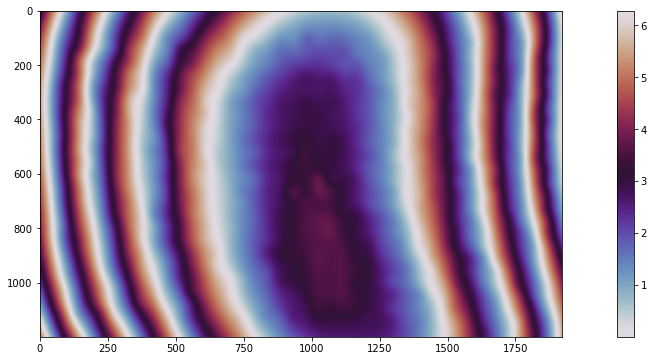

In [45]:
# Load the Santec correction
santec_correction = slm.load_vendor_phase_correction(
    file_path='Wavefront_correction_Data_221136000005(830nm).csv',  # Update this path to load your calibration
    smooth=True,
    overwrite=False
)

# Plot
plt.figure(figsize=(20,6))
plt.imshow(santec_correction, cmap="twilight", interpolation="none")
plt.colorbar()
plt.show()

Still, we can do better. The vendor-provided data only corrects for aberration on the SLM, but knows nothing of other beamline aberrations related to our setup. Additionally, information regarding source amplitude is valuable for holography. Calibrating these values is the goal of `FourierSLM.wavefront_calibrate()`.

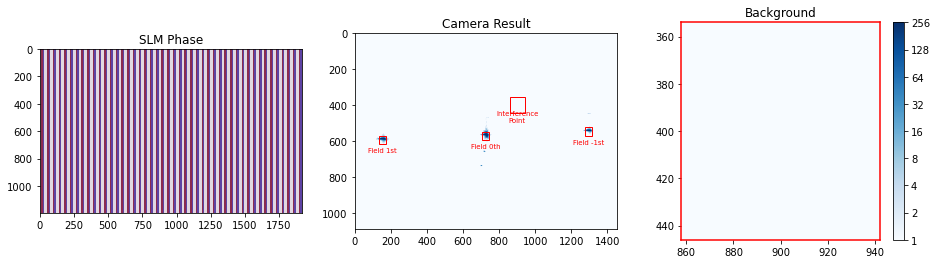

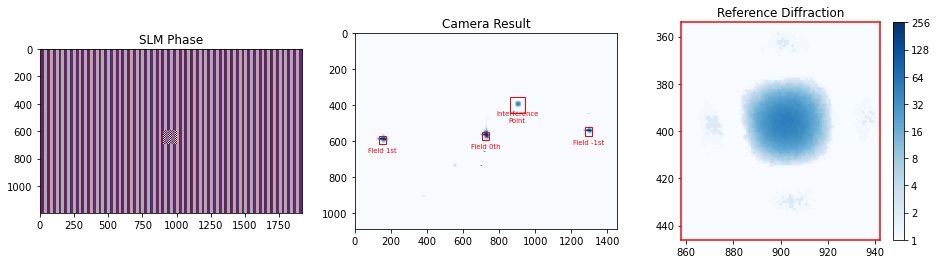

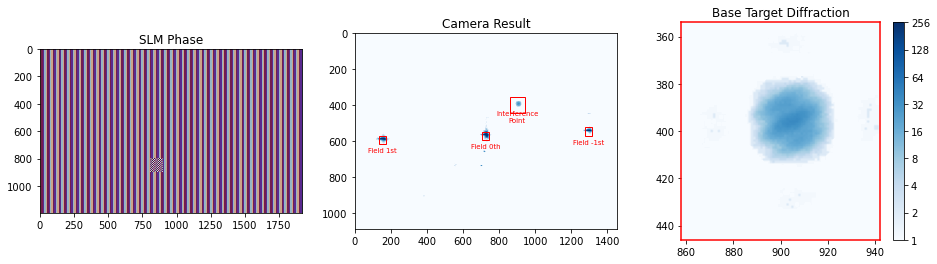

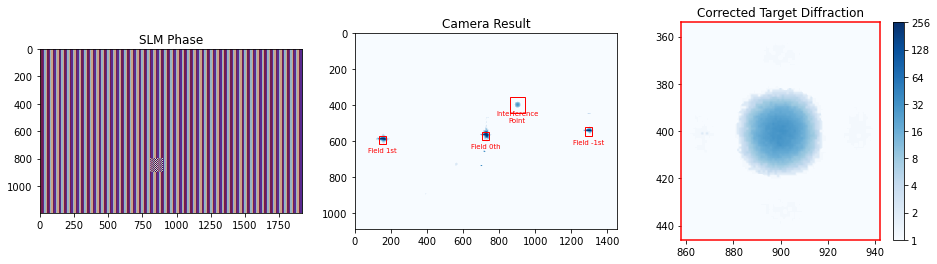

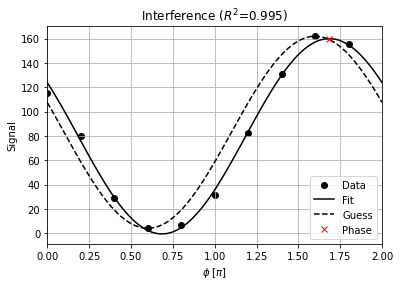

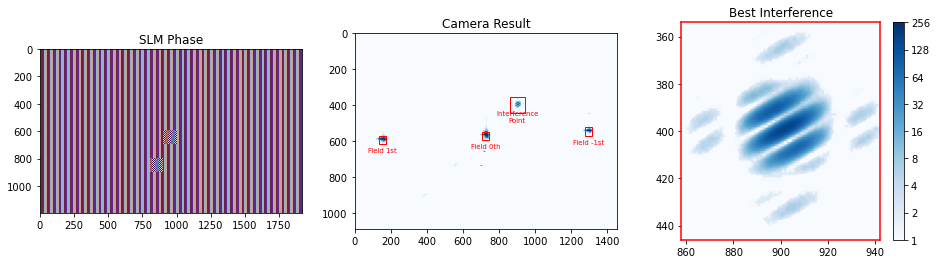

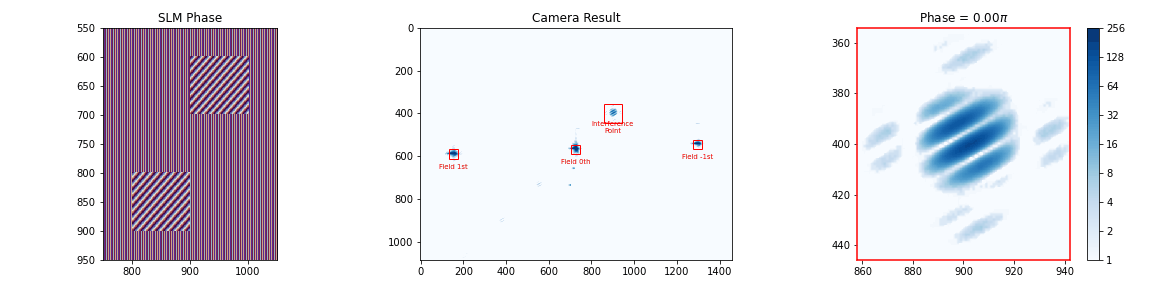

In [104]:
cam.set_exposure(5e-3)                 # Optimize exposure to see interference point
movie = fs.wavefront_calibrate(
    interference_point=(900, 400), 
    field_point=(.25, 0), 
    field_point_units="freq", 
    superpixel_size=100, 
    test_superpixel=(8, 8),             # Testing mode
    autoexposure=False,
    plot=3                              # Special mode to generate the phase .gif
)

# Generate the phase .gif
from IPython.display import Image
import imageio
imageio.mimsave('wavefront.gif', movie)
Image(filename="wavefront.gif")

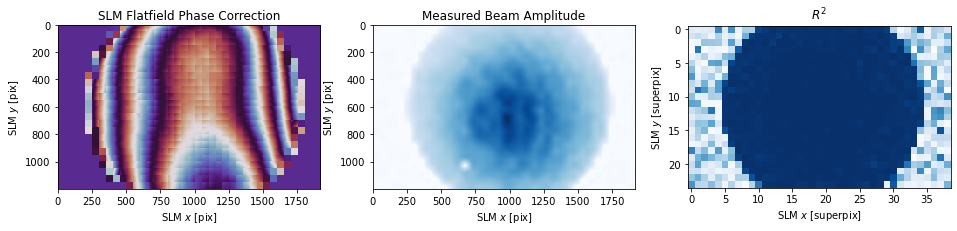

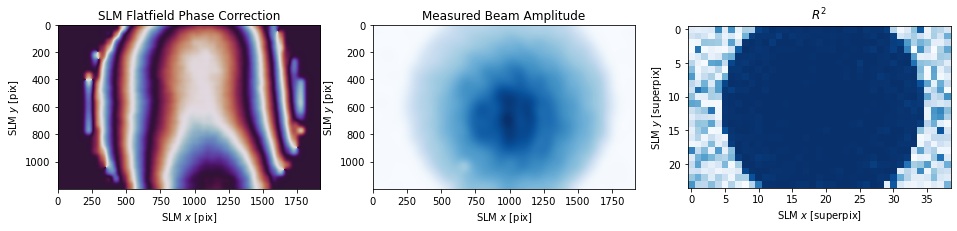

In [79]:
fs.load_wavefront_calibration(plot=True, smooth=False)      # Plot the unsmoothed...
fs.load_wavefront_calibration(plot=True)                    # ...and smoothed corrections

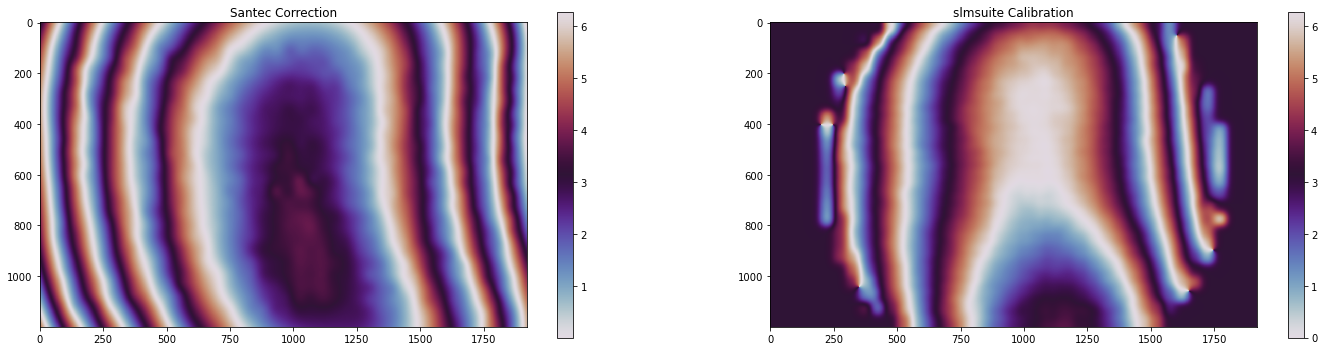

In [43]:
# Comparison plot
slmsuite_calibration = slm.phase_correction

_, axs = plt.subplots(1, 2, figsize=(24,6))

im0 = axs[0].imshow(santec_correction, cmap="twilight", interpolation="none")
axs[0].set_title("Santec Correction")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(slmsuite_calibration, cmap="twilight", interpolation="none")
axs[1].set_title("slmsuite Calibration")
plt.colorbar(im1, ax=axs[1])

plt.show()

### Spot Holography

In [11]:
spots = toolbox.lloyds_points(grid=fs.cam.shape, n_points=100)

plt.scatter(spots[0, :], spots[1, :])
plt.gca().set_ylim(np.flip(plt.gca().get_ylim()))
plt.show()

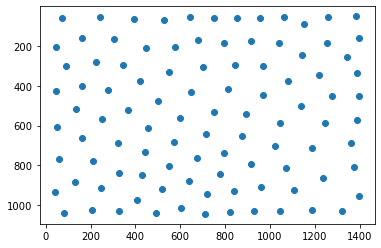

In [12]:
plt.scatter(spots[0, :], spots[1, :])
plt.gca().set_ylim(np.flip(plt.gca().get_ylim()))
plt.show()

In [13]:
hologram = SpotHologram(shape=(2048, 2048), spot_vectors=spots, basis="ij", cameraslm=fs)

100%|██████████| 20/20 [00:00<00:00, 38.13it/s]


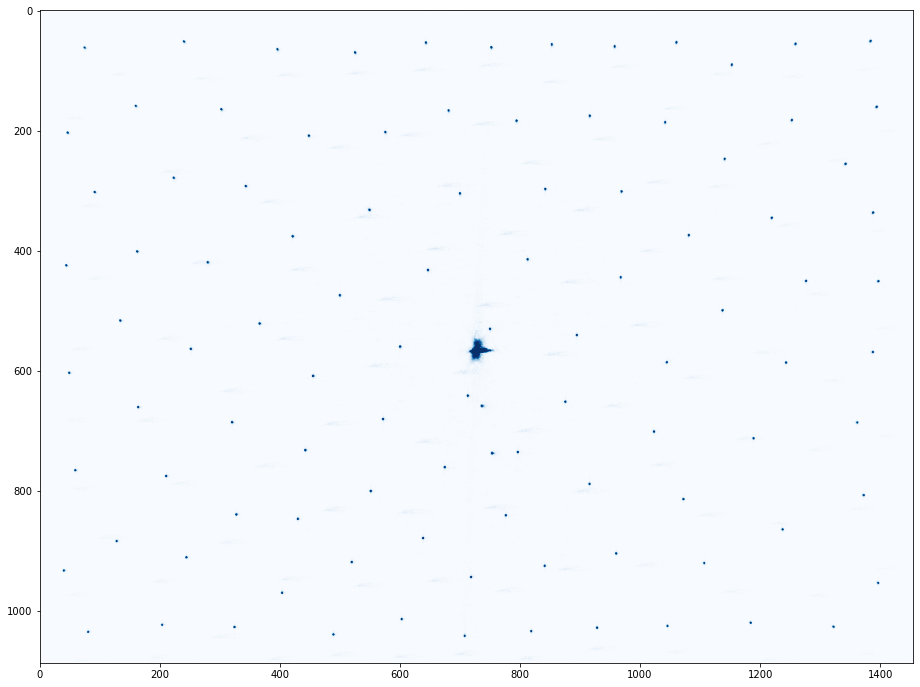

In [15]:
imgs = {}
cam.set_exposure(.01)
hologram.optimize(method="GS", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational GS')

### Demo Image Holography

In [16]:
folder = 'Santec Seminar slmsuite'
paths = [os.path.join(folder, path) for path in os.listdir(folder)]
paths = [path for path in paths if cv2.imread(path, cv2.IMREAD_GRAYSCALE) is not None]
print(paths)

['Santec Seminar slmsuite\\MIT.png', 'Santec Seminar slmsuite\\qp-slm.png', 'Santec Seminar slmsuite\\Santec.png']


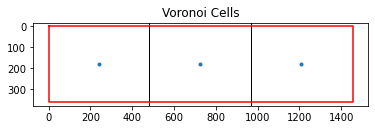

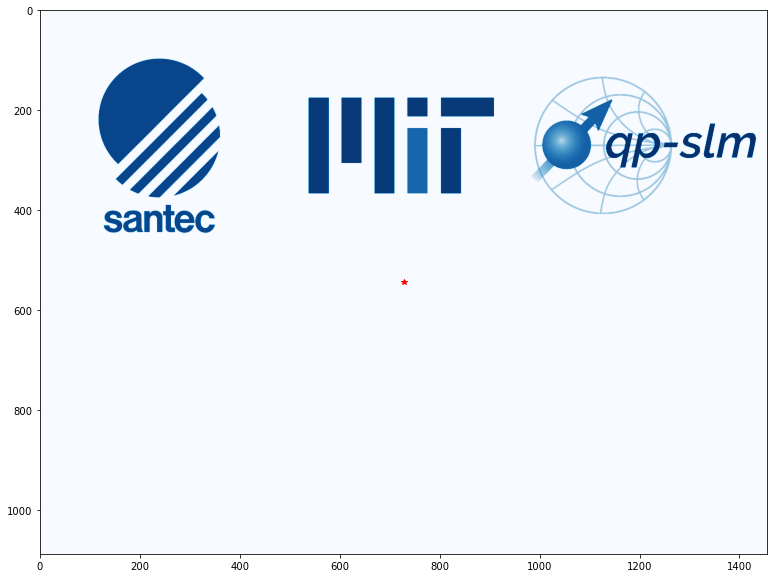

In [17]:
target_ij = load_composite_img(paths, plot=True)

Holography Datastructure

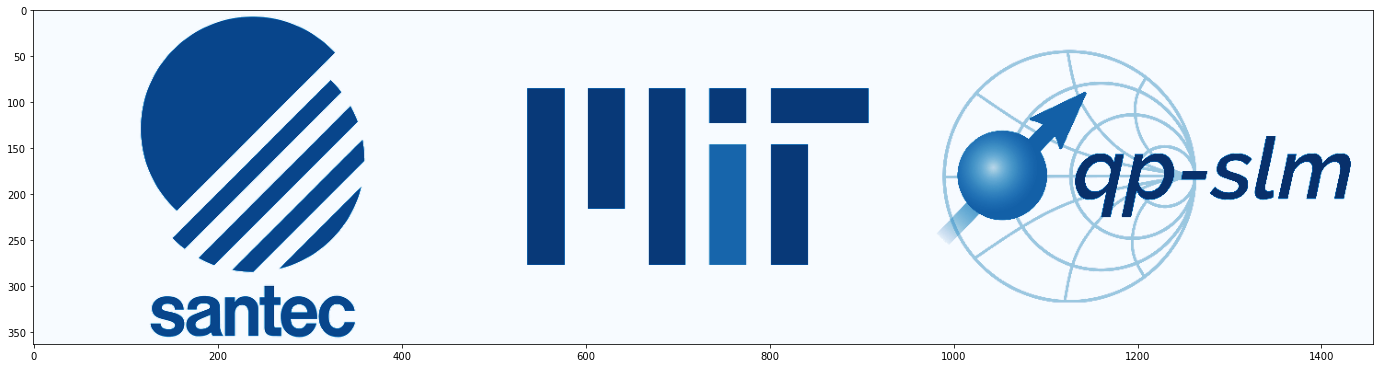

In [18]:
hologram = FeedbackHologram(shape=(2048, 2048), target_ij=target_ij, cameraslm=fs)
plot_target(target_ij)

Base GS Holography

100%|██████████| 20/20 [00:00<00:00, 42.41it/s]


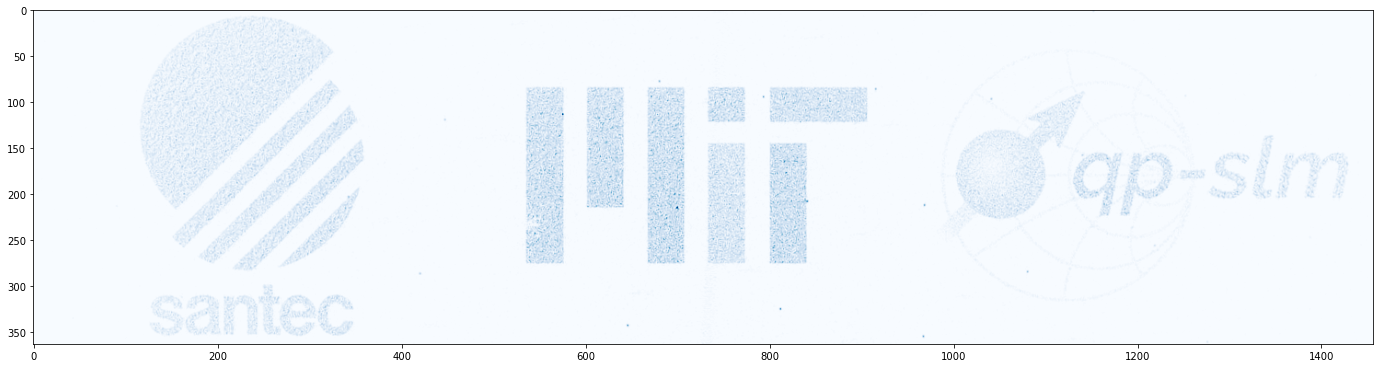

In [19]:
hologram.optimize(method="GS", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational GS', cyi=cyi, cyf=cyf)

In [ ]:
path = os.path.join(os.getcwd(), '../../source/static/qp-slm-small.png')

def load_img(path, target_shape=None, angle=0, shift=(-200, 0), plot=False):
    # Load the image.
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError("Image not found at path '{}'".format(path))

    # Invert if necessary such that the majority of the image is dark.
    if np.mean(img) > np.mean(cv2.bitwise_not(img)):
        img = cv2.bitwise_not(img)

    if angle != 0:
        img = ndimage.rotate(img, angle)

    if target_shape is not None:
        zoom_x = target_shape[0] / img.shape[0]
        zoom_y = target_shape[1] / img.shape[1]
        img = ndimage.zoom(img, min(zoom_x, zoom_y))

    # sqrt to get the amplitude.
    target_ij = toolbox.pad(analysis._make_8bit(np.sqrt(img)), fs.cam.shape)

    # Shift to the desired center.
    target_ij = np.roll(target_ij, shift, axis=(0,1))

    if plot:
        plot_img(target_ij)
        plt.show()

    return target_ij

def plot_img(target_ij):
    # Plot the desired camera space.
    plt.figure(figsize=(16,12))
    plt.imshow(target_ij)
    plt.plot(target_ij.shape[1]/2, target_ij.shape[0]/2, 'r*')

target_ij = load_img(path, plot=True);

Computational WGS Refinement

In [ ]:
hologram.optimize(method="WGS-Kim", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational WGS')

In [ ]:
hologram.plot_farfield(hologram.weights)

Experimental WGS Refinement

In [ ]:
hologram.optimize(  method="WGS-Kim", maxiter=10, feedback='experimental', 
                    stat_groups=['computational', 'experimental'], blur_ij=1)
plot_data(title=' Experimental WGS')

We lastly compare the target with these three results to demonstrate the usefulness of Fourier calibration and automated feedback for refining excellent holograms.

In [ ]:
# Get the mean power in all the image such that we can make a more direct comparison.
maxes = []

for x, key in enumerate(final_images.keys()):
    final_images[key] = final_images[key].astype(np.float64)
    final_images[key] *= 1/np.mean(final_images[key])
    maxes.append(np.amax(final_images[key]))

# Choose a clim which slightly saturates the images.
max = np.max(maxes) * .75

# Plot the images.
fig, axs = plt.subplots(4, 1, figsize=(20,20))

for x, key in enumerate(final_images.keys()):
    axs[x].imshow(final_images[key], vmin=0, vmax=max)
    axs[x].set_title(key)
    axs[x].xaxis.set_visible(False)
    axs[x].yaxis.set_visible(False)